# Часть 1.
Обучение модели.

In [15]:
import os

def build_one_model_tmp(input_folder, num_states, num_cep_coeff):
    # input_folder: path to the folder containing training wav files with the word
    # num_states: number of hidden states in HMM
    # num_cep_coeff: number of MFCC features extracted from each time window
    training_files = [x for x in os.listdir(input_folder) if x.endswith('.wav')]
    file_num = 0
    for filename in training_files:
        file_num += 1
        # Extract the current filepath and read the file
        filepath = os.path.join(input_folder, filename)
        print(filename)
        if file_num == 5:
            return
    return

input_folder = "Desktop/MNIST_9-25"
num_components = 15
num_cepstr = 29
for dirname in os.listdir(input_folder):
    # Get name of subfolder
    subfolder = os.path.join(input_folder, dirname)
    print("folder=",subfolder)
    if not os.path.isdir(subfolder):
        continue

        # Extract label
    label = subfolder[subfolder.rfind('/') + 1:]
    build_one_model_tmp(subfolder, num_states=num_components, num_cep_coeff=num_cepstr)

folder= Desktop/MNIST_9-25/num2
20_phone_2.wav
6_phone_2.wav
50_phone_2.wav
83_phone_2.wav
62_phone_2.wav
folder= Desktop/MNIST_9-25/num5
93_phone_5.wav
109_phone_5.wav
30_phone_5.wav
40_phone_5.wav
72_phone_5.wav
folder= Desktop/MNIST_9-25/num4
72_phone_4.wav
40_phone_4.wav
30_phone_4.wav
93_phone_4.wav
86_phone_4.wav
folder= Desktop/MNIST_9-25/num3
12_phone_3.wav
105_phone_3.wav
62_phone_3.wav
83_phone_3.wav
50_phone_3.wav
folder= Desktop/MNIST_9-25/num8
75_phone_8.wav
88_phone_8.wav
47_phone_8.wav
37_phone_8.wav
94_phone_8.wav
folder= Desktop/MNIST_9-25/num6
67_phone_6.wav
17_phone_6.wav
49_phone_6.wav
39_phone_6.wav
25_phone_6.wav
folder= Desktop/MNIST_9-25/num1
59_phone_1.wav
29_phone_1.wav
77_phone_1.wav
96_phone_1.wav
35_phone_1.wav
folder= Desktop/MNIST_9-25/num0
45_phone_0.wav
35_phone_0.wav
29_phone_0.wav
59_phone_0.wav
12_phone_0.wav
folder= Desktop/MNIST_9-25/num7
86_phone_7.wav
55_phone_7.wav
3_phone_7.wav
25_phone_7.wav
39_phone_7.wav
folder= Desktop/MNIST_9-25/num9
19_ph

In [16]:
import os
def build_one_model(input_folder, num_states, num_cep_coeff):
    # input_folder: path to the folder containing training wav files with the word
    # num_states: number of hidden states in HMM
    # num_cep_coeff: number of MFCC features extracted from each time window
    X = np.array([])  # features
    training_files = [x for x in os.listdir(input_folder) if x.endswith('.wav')]
    for filename in training_files:
        # Extract the current filepath and read the file
        filepath = os.path.join(input_folder, filename)
        sampling_freq, signal = wavfile.read(filepath)
        sound = AudioSegment.from_file(filepath, format="wav")
        duration = len(sound)

        start_trim = detect_leading_silence(sound)
        end_trim = detect_leading_silence(sound.reverse())
        duration = len(sound)
        trimmed_sound = sound[start_trim:duration - end_trim]
        trimmed_sound.export("tmp.wav", format="wav")
        # Extract features
        # Default values:
        # winlen=0.025, winstep=0.01, nfft=512,
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            features_mfcc = mfcc(signal, sampling_freq, numcep=num_cep_coeff)

        # Append features to the variable X
        if len(X) == 0:
            X = features_mfcc
        else:
            X = np.append(X, features_mfcc, axis=0)

    # Initiate HMM model object
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        model = ModelHMM(num_components=num_states)

    # Train HMM model, calculate likelihood of the sample by the trained model
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        model.train(X)
        model_score = model.compute_score(X)

    return model, model_score, num_cep_coeff

In [17]:
from hmmlearn import hmm
class ModelHMM(object):
    def __init__(self, num_components=8, num_iter=1000):
        self.n_components = num_components
        self.n_iter = num_iter
    # Define the covariance type and the type of HMM:
        self.cov_type = 'diag'
        self.model_name = 'GaussianHMM'
    # Initialize the variable in which we will store the models for each word:
        self.models = []
    # Define the model using the specified parameters:
        self.model = hmm.GaussianHMM(n_components=self.n_components,
                covariance_type=self.cov_type,n_iter=self.n_iter)

    # Define a method to train the model
    # 'training_data' is a 2D numpy array where each row has length of number of mfcc coefficients
    def train(self, training_data):
        np.seterr(all='ignore')
        cur_model = self.model.fit(training_data)
        self.models.append(cur_model)

    # Define a method to compute log likelihood score for input features
    def compute_score(self, input_data):
        return self.model.score(input_data)  # model.score returns log likelihood of sample input_data


In [18]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [19]:
def build_models(input_folder):

    # input_folder contains subfolders with samples of words in wav files

    # Initialize the variable to store all the models
    speech_models = []

    # Parse the input directory
    for dirname in os.listdir(input_folder):

        # Get name of subfolder
        subfolder = os.path.join(input_folder, dirname)

        if not os.path.isdir(subfolder):
            continue

        # Extract label
        label = subfolder[subfolder.rfind('/') + 1:]

        # Fit model for label
        model = build_one_model(subfolder, num_states=num_components, num_cep_coeff=num_cepstr)

        # Add the model to the list
        speech_models.append((model, label))

        # Reset model variable
        model = None
        print("Fitted "+dirname)
    return speech_models

In [20]:
import numpy as np
from scipy.io import wavfile
from scipy.io.wavfile import write
from pydub import AudioSegment
import warnings
import python_speech_features
from python_speech_features import mfcc
digit_models = build_models(input_folder)

Fitted num2
Fitted num5
Fitted num4
Fitted num3
Fitted num8
Fitted num6
Fitted num1
Fitted num0
Fitted num7
Fitted num9


In [21]:
from sklearn.externals import joblib
joblib.dump(digit_models,'saved.pkl')

['saved.pkl']

# Часть 2.
Распознавание цифр телефона по сохраненной модели

In [22]:
speech_models = joblib.load('saved.pkl')

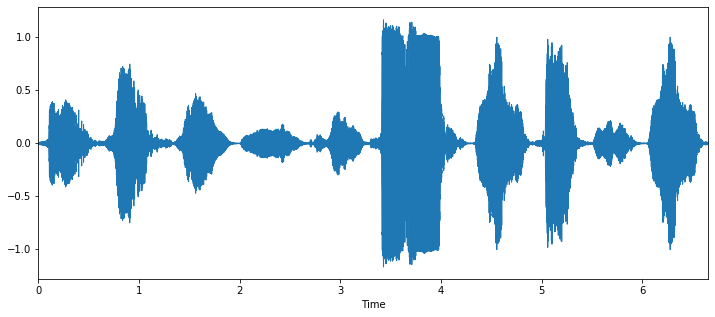

Signal rate=  22050


In [23]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
wavfile = "Desktop/test/0/1.wav"
#data, rate = sf.read(wavfile, dtype='float32')
x, sr = librosa.load(wavfile)
# Plot the sample.
plt.figure(figsize=(12, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()
print("Signal rate= ",sr)

In [24]:
from pydub import AudioSegment
from pydub.silence import split_on_silence
sound_file = AudioSegment.from_wav(wavfile)


In [25]:
def find_optimal_silence(sound_file, silence_len ):
        thresh = - 40
        silence_len = 80
        audio_chunks = split_on_silence(sound_file, min_silence_len=silence_len, silence_thresh=thresh)
        i = 0
        while (len(audio_chunks)!=10):
            i = i+1
            if (i == 15):
                thresh = thresh + 1
            else:
                if len(audio_chunks) < 10:
                    silence_len = silence_len - 1 
                else: 
                    if len(audio_chunks) > 10:
                        silence_len = silence_len + 1 
            audio_chunks = split_on_silence(sound_file, min_silence_len=silence_len, silence_thresh=thresh)
        return audio_chunks
    

In [26]:
def score_one_word(trained_model, test_file_path):
    # trained_model: ModelHMM object with trained model
    # test_file_path: path to wav file
    sampling_freq, signal = read(test_file_path)
    num_cep_coeff = trained_model[2]

    # Extract features
    # Default values:
    # winlen=0.025, winstep=0.01, nfilt=26, nfft=512,
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        features_mfcc = mfcc(signal, sampling_freq, numcep=num_cep_coeff)

        # Calculate log likelihood
        word_score = trained_model[0].compute_score(features_mfcc)
    return word_score

In [27]:
def find_best_predicted():
    max_score = -float('inf')
        # Run the current feature vector through all the HMM
        #  models and pick the one with the highest score
    for item in speech_models:
        model, label = item
            # Evaluate the score and compare against the maximum score:
        score = score_one_word(model, "tmp.wav")
        if score > max_score:
            max_score = score
            predicted_label = label
    return predicted_label

In [28]:
import csv
from scipy.io.wavfile import read
with open('result.csv', mode='w', newline='') as file: 
    writer = csv.writer(file, delimiter = ",", quoting=csv.QUOTE_MINIMAL)
    for i in range(0,300):
        wavfile = "Desktop/test/20/"
        wavfile = wavfile + str(i) + ".wav"
        sound_file = AudioSegment.from_wav(wavfile)
        silence_len = 100
        x = find_optimal_silence(sound_file, silence_len)
        answer = ''
        for j in range(0,10):    
            x[j].export("tmp.wav", format="wav")
            num = find_best_predicted()
            answer = answer+num[3]
        print(i, ' ', answer)
        writer.writerow((i, answer))
    
    

0   3451907507
1   7969219996
2   4364835866
3   5998594554
4   9804739398
5   8796263011
6   4081134799
7   1874572730
8   9258529833
9   0592286522
10   7282449438
11   6478906795
12   6784256975
13   2378395898
14   5106867032
15   2943735497
16   3253221931
17   2801025256
18   7436990995
19   3465581368
20   2433226876
21   8925971902
22   7294383193
23   5898964638
24   9809853232
25   7396861299
26   9631935766
27   9144692505
28   2402683328
29   7124379049
30   2159992375
31   4654273334
32   2285255877
33   3557341149
34   1988513804
35   9676162419
36   5935015546
37   6648324273
38   2999459455
39   9357181033
40   6718435656
41   7739694876
42   9434237141
43   0794722577
44   5837499233
45   7923031943
46   3341780369
47   6799224142
48   8849297889
49   8252018154
50   1970269442
51   8062916250
52   6734947884
53   6472390165
54   6625290457
55   4685921618
56   3710979754
57   9817808665
58   1369509185
59   1341314400
60   6643850450
61   7173007197
62   9565386814
63